# PAGA for hematopoiesis in mouse [(Paul *et al.*, 2015)](https://doi.org/10.1016/j.cell.2015.11.013)

Hematopoiesis: trace myeloid and erythroid differentiation for data of [Paul *et al.* (2015)](http://doi.org/10.1016/j.cell.2015.11.013).

The results here differ slightly from the current preprint, we changed to a deterministic PCA that is reproducible across computational platforms. The notebook will be polished soon. The previous version can be found [here](https://github.com/theislab/paga/blob/b100a55934eaac73de6c92681f6c3510c02c9f10/blood/paul15/paul15.ipynb).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy.api as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/paul15.h5ad'
results_file_denoised = './write/paul15_denoised.h5ad'

scanpy==1.3.2 anndata==0.6.10+31.g4c40622 numpy==1.14.5 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

Note: The following function is also available as `sc.datasets.paul15()`.

In [3]:
adata = sc.datasets.paul15()

... storing 'paul15_clusters' as categorical


In [4]:
adata

AnnData object with n_obs × n_vars = 2730 × 3451 
    obs: 'paul15_clusters'
    uns: 'iroot'

## Preprocessing and Visualization

Apply a simple [preprocessing recipe](https://scanpy.readthedocs.io/en/latest/api/scanpy.api.pp.recipe_zheng17.html).

In [5]:
sc.pp.recipe_zheng17(adata)

running recipe zheng17
    finished (0:00:00.22)


In [6]:
sc.tl.pca(adata, svd_solver='arpack')

In [7]:
sc.tl.tsne(adata, n_pcs=30)

computing tSNE
    using 'X_pca' with n_pcs = 30
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:20.55) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


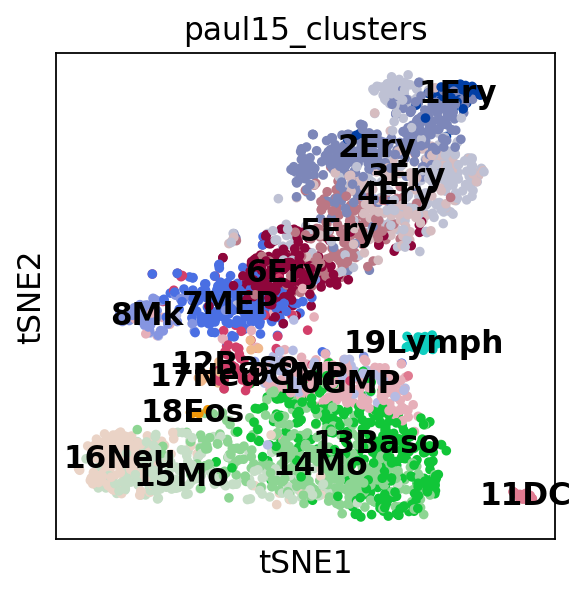

In [8]:
sc.pl.tsne(
    adata, color='paul15_clusters',
    palette=sc.pl.palettes.default_26,
    legend_loc='on data')

Let us also visualize the data using graph drawing.

In [9]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:04.92) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
drawing single-cell graph using layout "fa"
    finished (0:00:15.02) --> added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm)


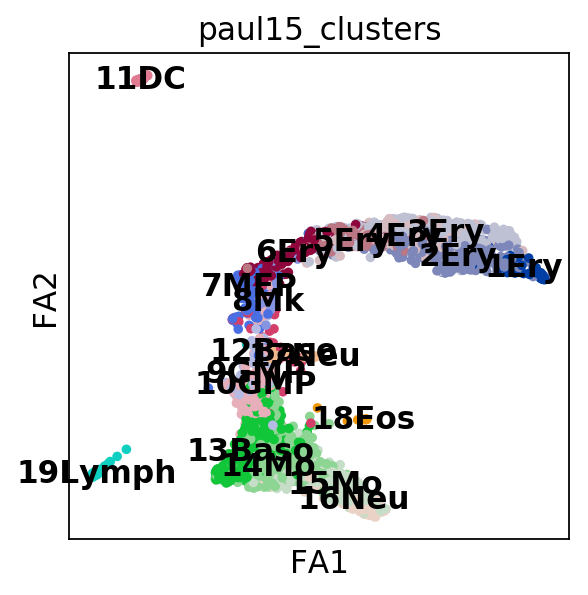

In [10]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

In [11]:
adata.write(results_file)

Recompute the graph using diffusion maps. Truncating at a few diffusion components amounts to denoising the graph - we just take a few of the first spectral components; this is very similar to denoising a data matrix using PCA.

In [12]:
adata_denoised = sc.read(results_file)
sc.tl.diffmap(adata_denoised)
sc.pp.neighbors(adata_denoised, n_neighbors=10, use_rep='X_diffmap')

computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         1.         0.9989277  0.99671    0.9943037  0.9893978
     0.9883686  0.9873107  0.983987   0.983007   0.9790806  0.97625506
     0.97443664 0.97291625 0.9652971 ]
    finished (0:00:00.11) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)
computing neighbors
    finished (0:00:01.43) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [13]:
sc.tl.draw_graph(adata_denoised)

drawing single-cell graph using layout "fa"
    finished (0:00:13.67) --> added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm)


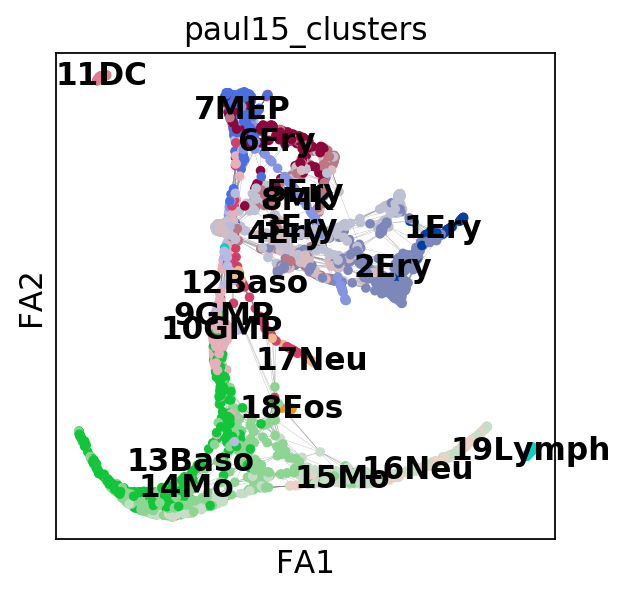

In [14]:
sc.pl.draw_graph(adata_denoised, color='paul15_clusters', legend_loc='on data', edges=True)

In [15]:
adata_denoised.write(results_file_denoised)

## Clustering

In [16]:
adata = sc.read(results_file_denoised)

In [17]:
sc.tl.louvain(adata, resolution=0.8)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.10) --> found 23 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


Annotate the clusters using marker genes.

| cell type | marker |
| --- | --- |
|HSCs | Procr |
|Erythroids | Gata1, Klf1, Epor, Gypa, Hba-a2, Hba-a1, Spi1 |
|Neutrophils | Elane, Cebpe, Ctsg, Mpo, Gfi1 |
|Monocytes | Irf8, Csf1r, Ctsg, Mpo |
|Megakaryocytes | Itga2b (encodes protein CD41), Pbx1, Sdpr, Vwf |
|Basophils | Mcpt8, Prss34 |
|B cells | Cd19, Vpreb2, Cd79a |
|Mast cells| Cma1, Gzmb, CD117/C-Kit |
|Mast cells & Basophils| Ms4a2, Fcer1a, Cpa3, CD203c (human)|

In [18]:
sc.tl.paga(adata, groups='louvain')

running partition-based graph abstraction (PAGA)
    finished (0:00:00.15) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)


--> added 'pos', the PAGA positions (adata.uns['paga'])


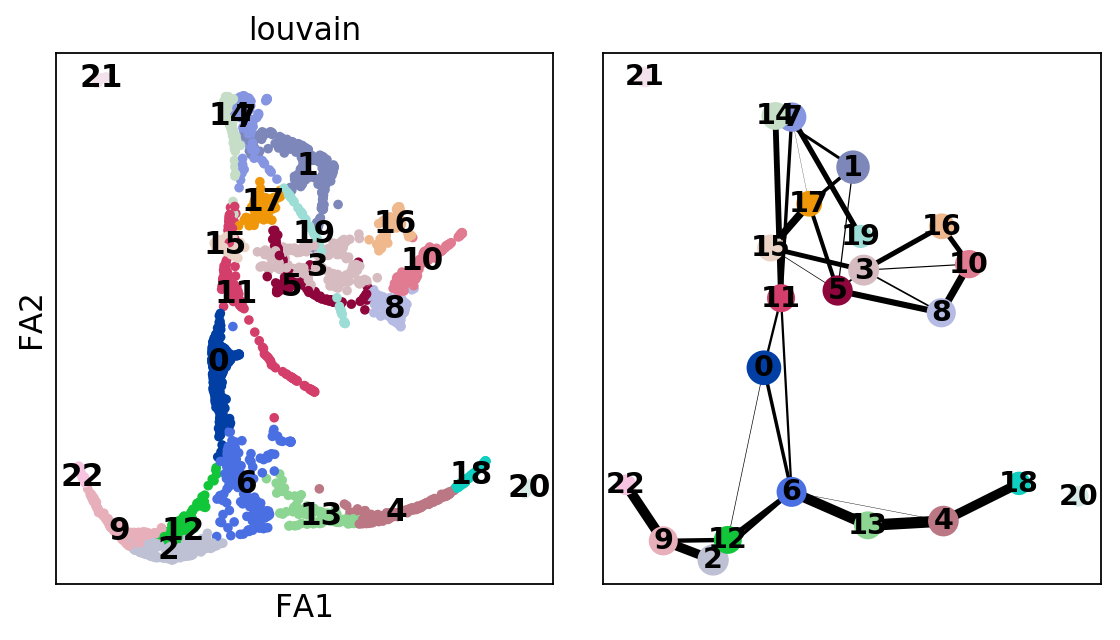

In [19]:
sc.pl.paga_compare(adata, color='louvain')

It looks like we should recluster cluster 11.

In [20]:
sc.tl.louvain(adata, resolution=0.1, restrict_to=('louvain', ['11']))

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 2 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical)


running partition-based graph abstraction (PAGA)
    finished (0:00:00.15) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
--> added 'pos', the PAGA positions (adata.uns['paga'])


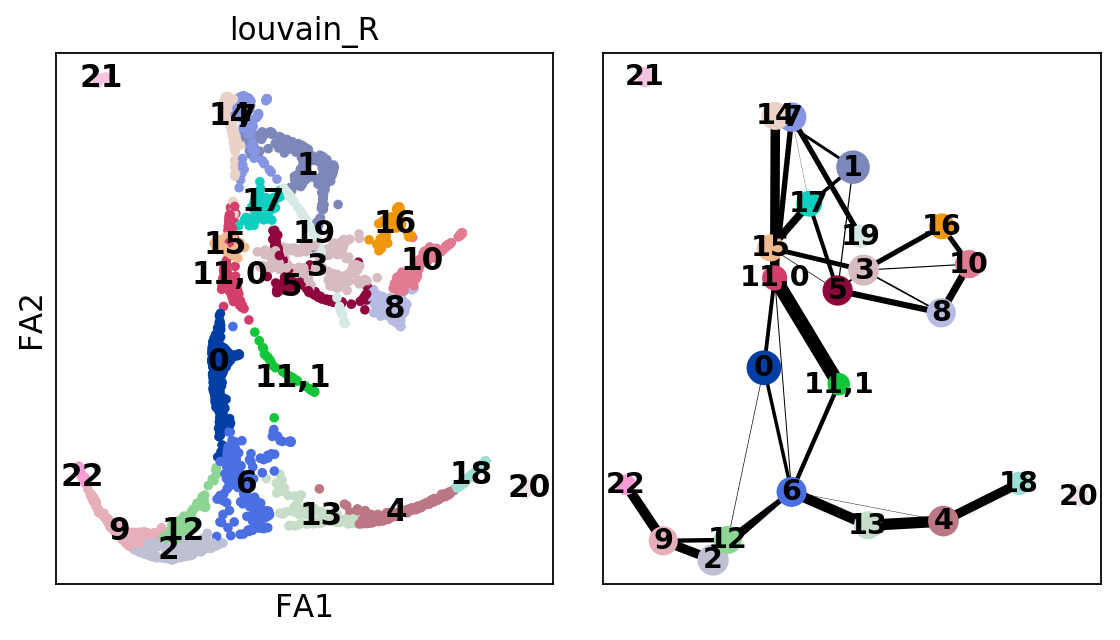

In [21]:
sc.tl.paga(adata, groups='louvain_R')
sc.pl.paga_compare(adata)

--> added 'pos', the PAGA positions (adata.uns['paga'])
saving figure to file ./figures/paga_annotation.pdf


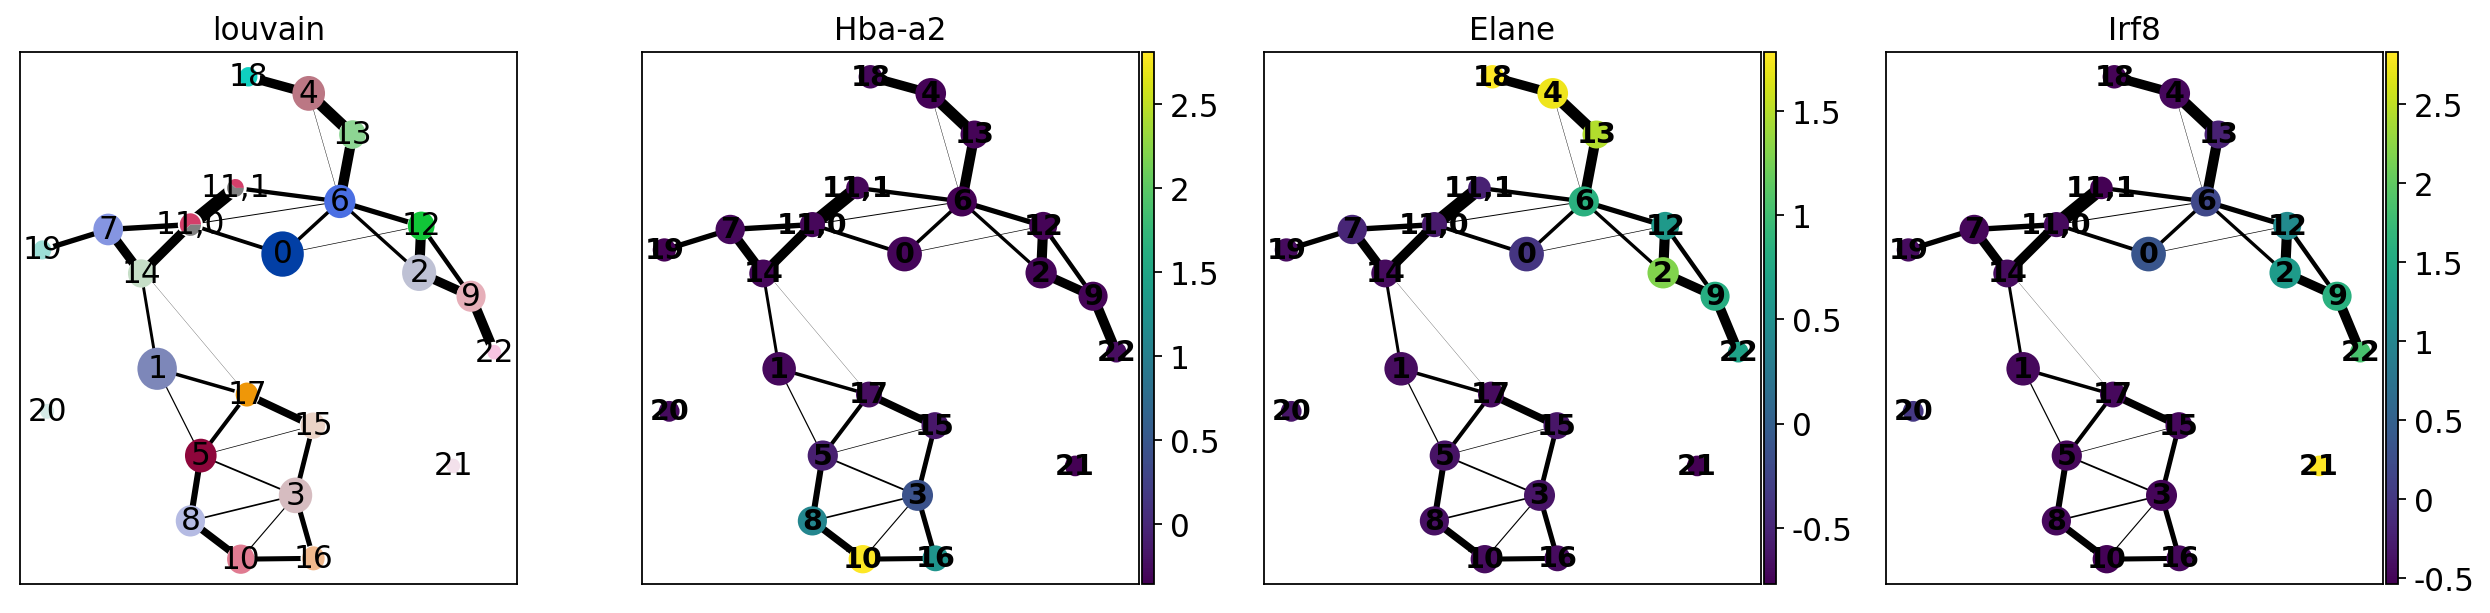

In [22]:
sc.pl.paga(adata, color=['louvain', 'Hba-a2', 'Elane', 'Irf8'], save='_annotation')

--> added 'pos', the PAGA positions (adata.uns['paga'])


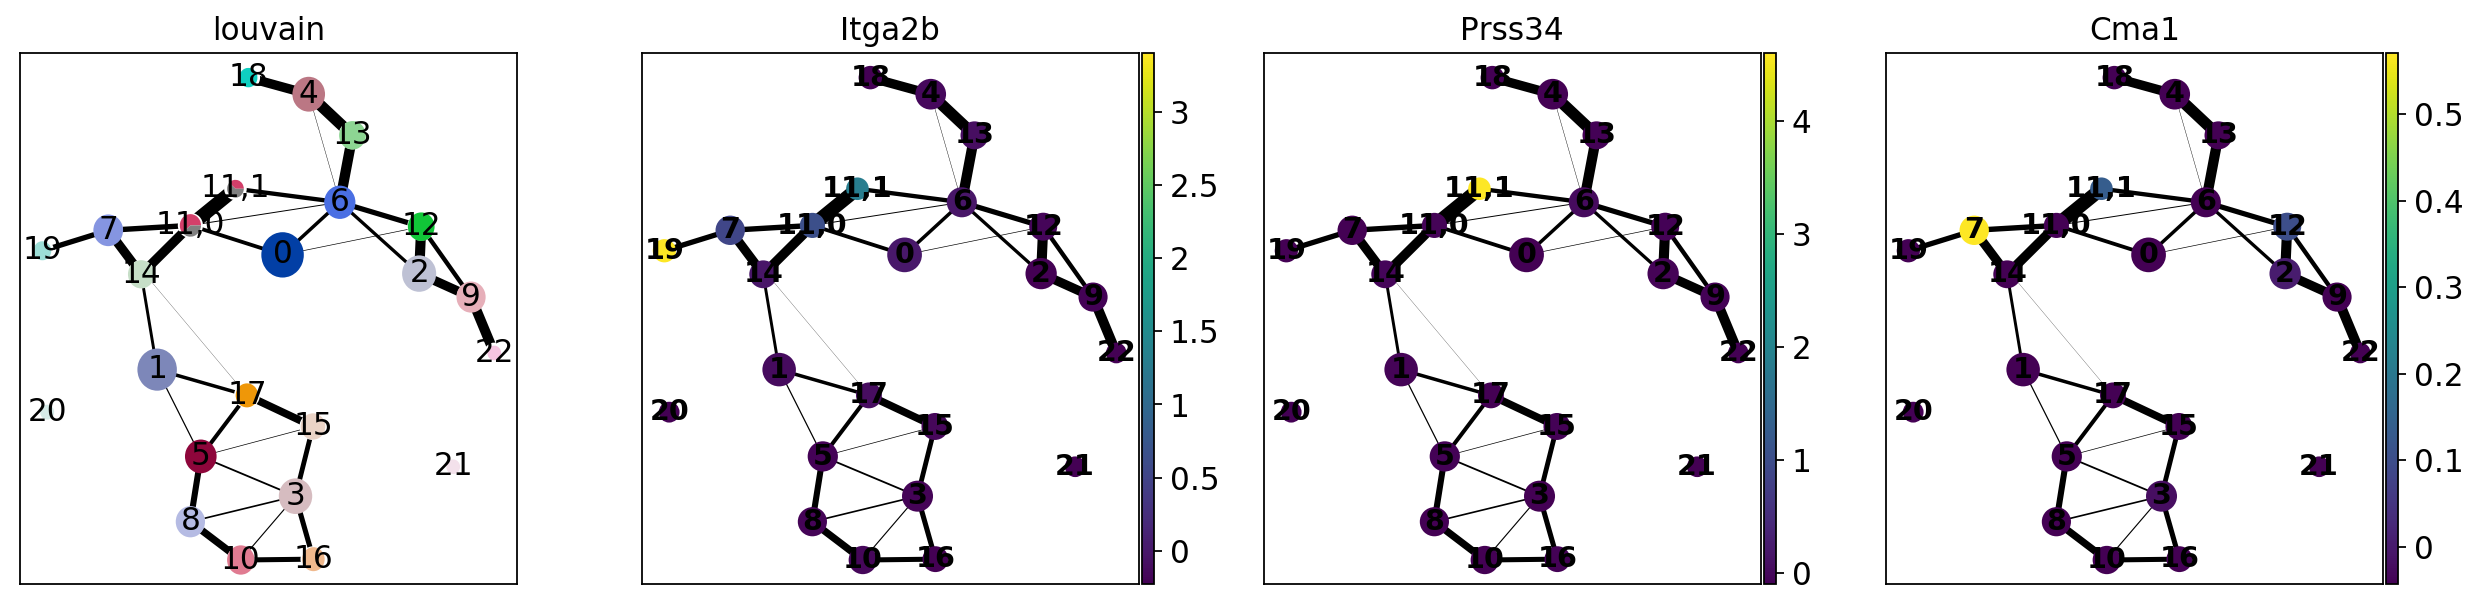

In [23]:
sc.pl.paga(adata, color=['louvain', 'Itga2b', 'Prss34', 'Cma1'])

Actually label the clusters --- note that Cma1 is a Mast cell marker and only appears in a small fraction of the cells in the progenitor/stem cell cluster 6, see below.

In [24]:
adata.obs['louvain_anno'] = adata.obs['louvain_R']

In [39]:
adata.obs['louvain_anno'].cat.categories = [
    '0', '1', '2', '3', '4', '5', '6/Stem', '7', '8', '9', '10/Ery', '11', '12/Baso', '13',
    '14', '15', '16', '17', '18', '19/Neu', '20/Mk', '21', '22', '23/Mo']

Of course, we can also visualize this on a single-cell embedding.

saving figure to file ./figures/draw_graph_fa_annotation.pdf


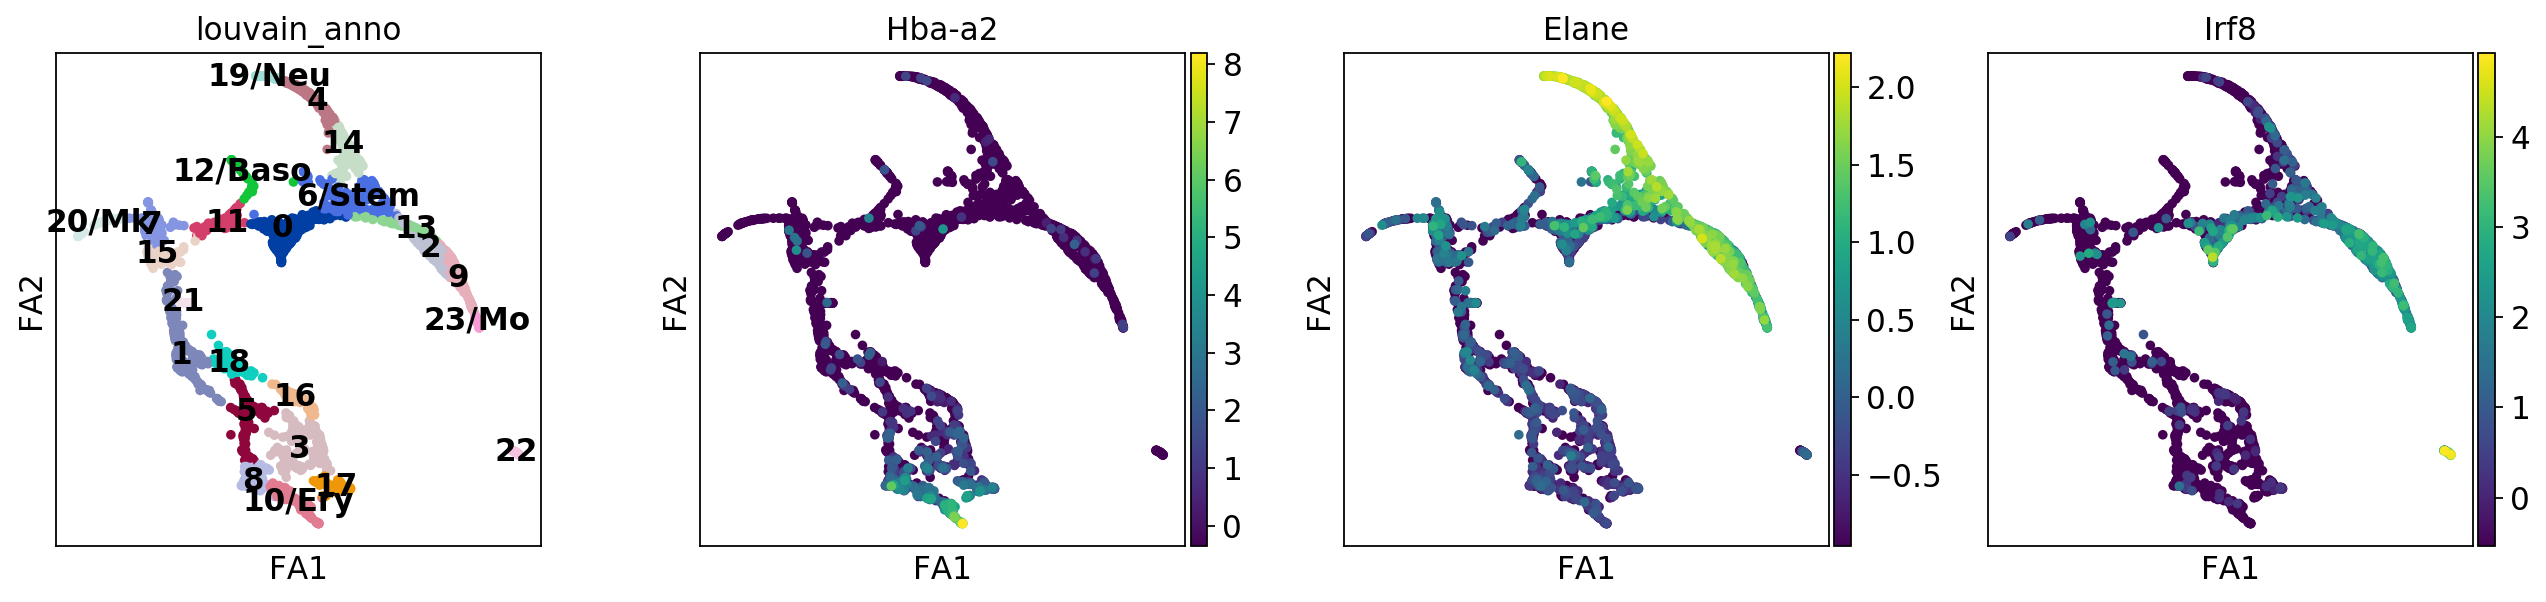

In [40]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'Hba-a2', 'Elane', 'Irf8'], legend_loc='on data', save='_annotation')

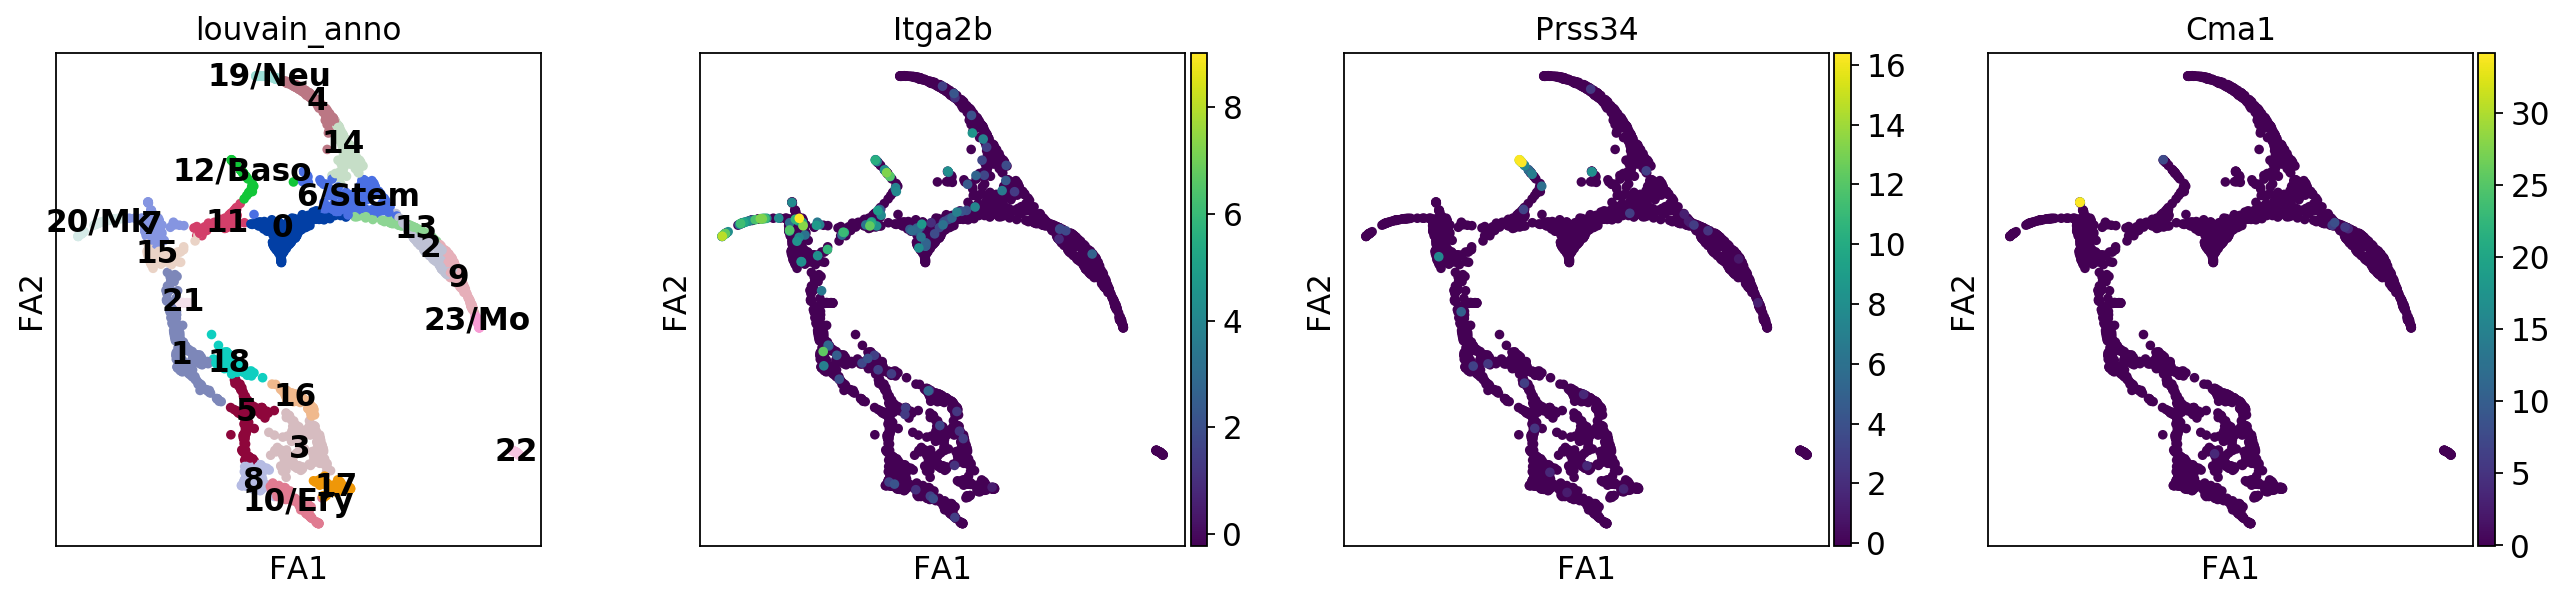

In [41]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'Itga2b', 'Prss34', 'Cma1'], legend_loc='on data')

In [42]:
adata.write(results_file_denoised)

## PAGA

In [3]:
adata = sc.read(results_file_denoised)

In [4]:
sc.tl.paga(adata, groups='louvain_anno')

running partition-based graph abstraction (PAGA)
    finished (0:00:00.15) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)


--> added 'pos', the PAGA positions (adata.uns['paga'])


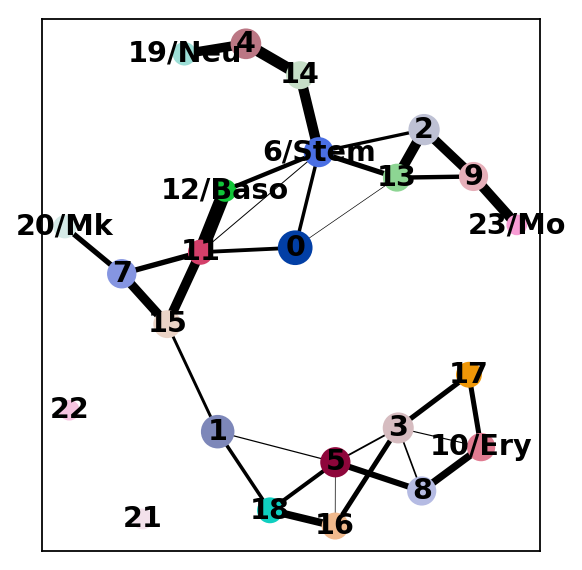

In [5]:
sc.pl.paga(adata, threshold=0.03)

In [6]:
sc.tl.draw_graph(adata, init_pos='paga')

drawing single-cell graph using layout "fa"
    finished (0:00:11.92) --> added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm)


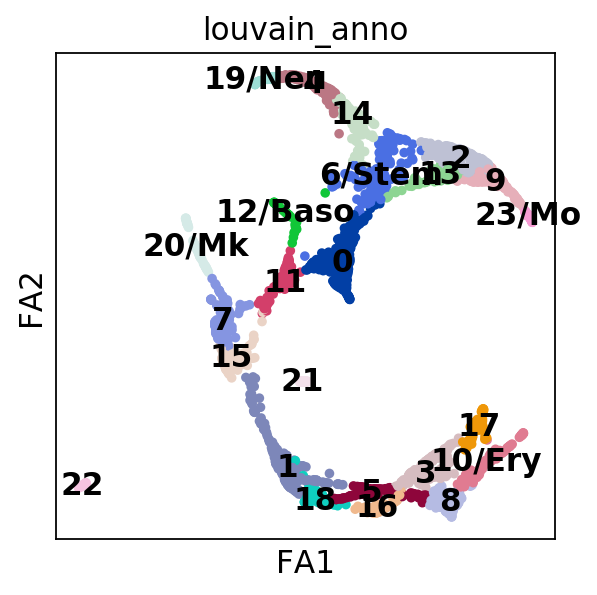

In [7]:
sc.pl.draw_graph(adata, color='louvain_anno', legend_loc='on data')

Choose the colors a bit more consistently (currently not done).

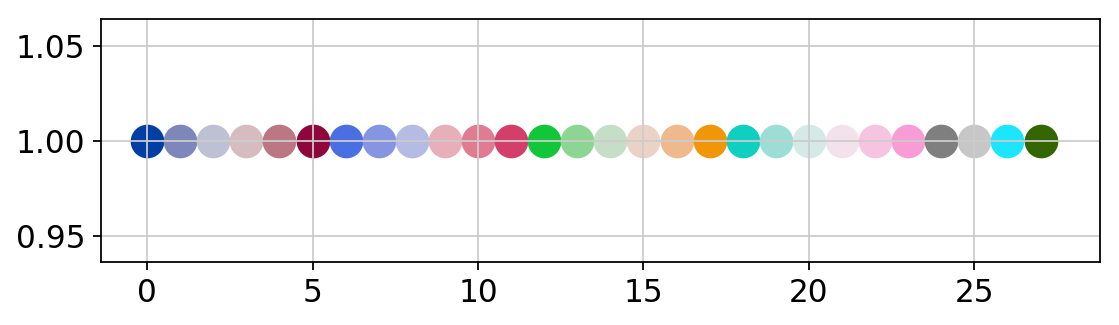

In [8]:
pl.figure(figsize=(8, 2))
for i in range(28):
    pl.scatter(i, 1, c=sc.pl.palettes.zeileis_26[i], s=200)
pl.show()

In [9]:
orig_colors = np.array(sc.pl.palettes.zeileis_26)
new_colors = orig_colors.copy()

In [10]:
new_colors[[6]] = orig_colors[[12]]  # Stem colors / green
new_colors[[13, 16, 1, 7, 8]] = orig_colors[[5, 11, 10, 9, 21]]  # Ery colors / red
new_colors[[17]] = orig_colors[[17]]  # Mk early Ery colors / yellow
new_colors[[10, 11, 12]] = orig_colors[[2, 8, 20]]  # lymph progenitors / grey
new_colors[[18]] = orig_colors[[18]]  # Baso / turquoise
new_colors[[5, 2]] = orig_colors[[6, 7]]  # Neu / light blue
new_colors[[9, 0]] = orig_colors[[0, 1]]  # Mo / dark blue

In [11]:
adata.uns['clusters_colors'] = new_colors

And add some white space to some cluster names.

--> added 'pos', the PAGA positions (adata.uns['paga'])


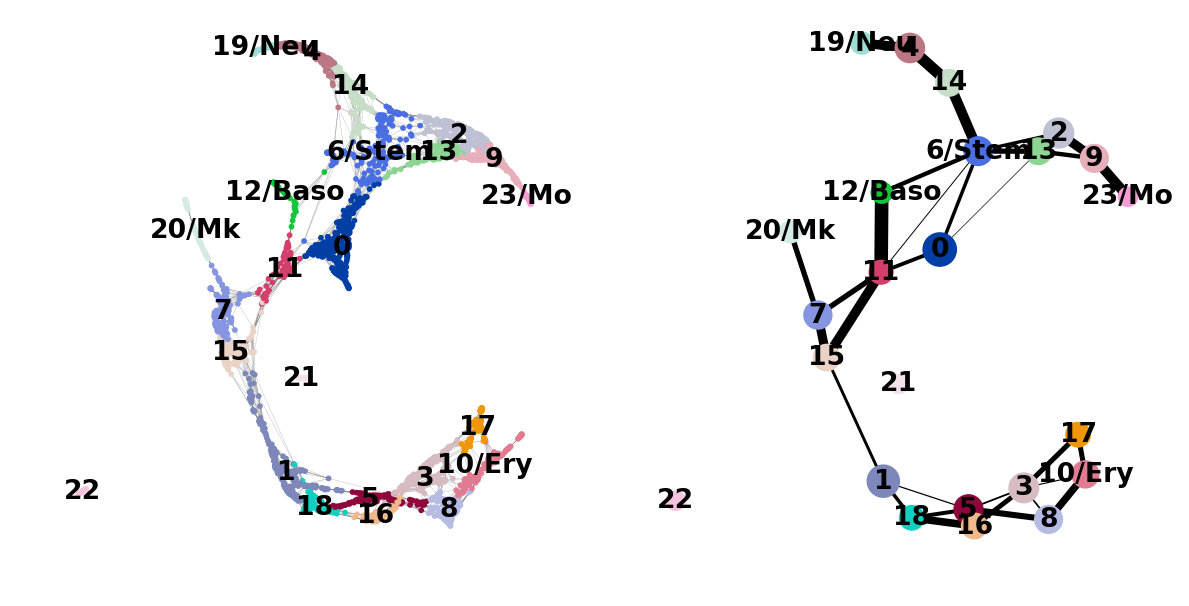

In [13]:
axs = sc.pl.paga_compare(
    adata, threshold=0.03, title='', right_margin=0.2, size=10, 
    legend_fontsize=12, fontsize=12, frameon=False)

Previous figure, based on randomized PCA on different computational environment.

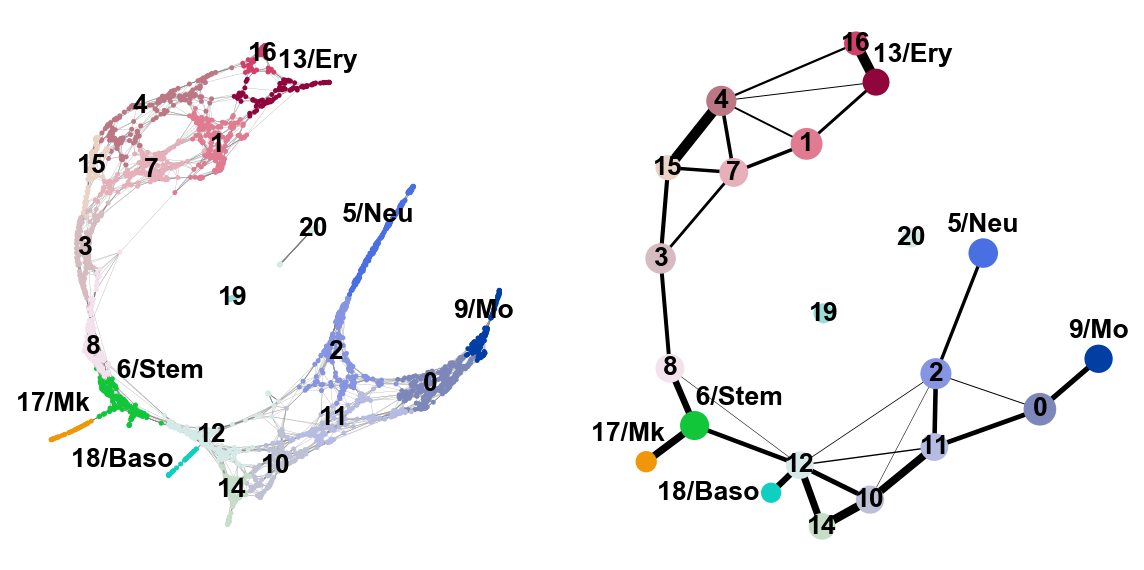

In [61]:
pl.sca(axs[0])
pl.xlabel('')
pl.ylabel('')
axs[0].set_frame_on(False)
pl.savefig('./figures/paga_compare_paul15.pdf')
pl.show()

In [62]:
adata.write(results_file_denoised)

### Reconstructing gene changes along PAGA paths for a given set of genes

In [63]:
adata = sc.read(results_file_denoised)

In [64]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['paul15_clusters']  == '7MEP')[0]

In [65]:
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00.00) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)


In [66]:
adata.write(results_file_denoised)

Select some of the marker gene names.

In [67]:
gene_names = ['Gata2', 'Gata1', 'Klf1', 'Epor', 'Hba-a2',  # erythroid
              'Elane', 'Cebpe', 'Gfi1',                    # neutrophil
              'Irf8', 'Csf1r', 'Ctsg']                     # monocyte

Use the full raw data for visualization.

In [68]:
adata_raw = paul15()
sc.pp.log1p(adata_raw)
sc.pp.scale(adata_raw)
adata.raw = adata_raw

... storing 'paul15_clusters' as categorical


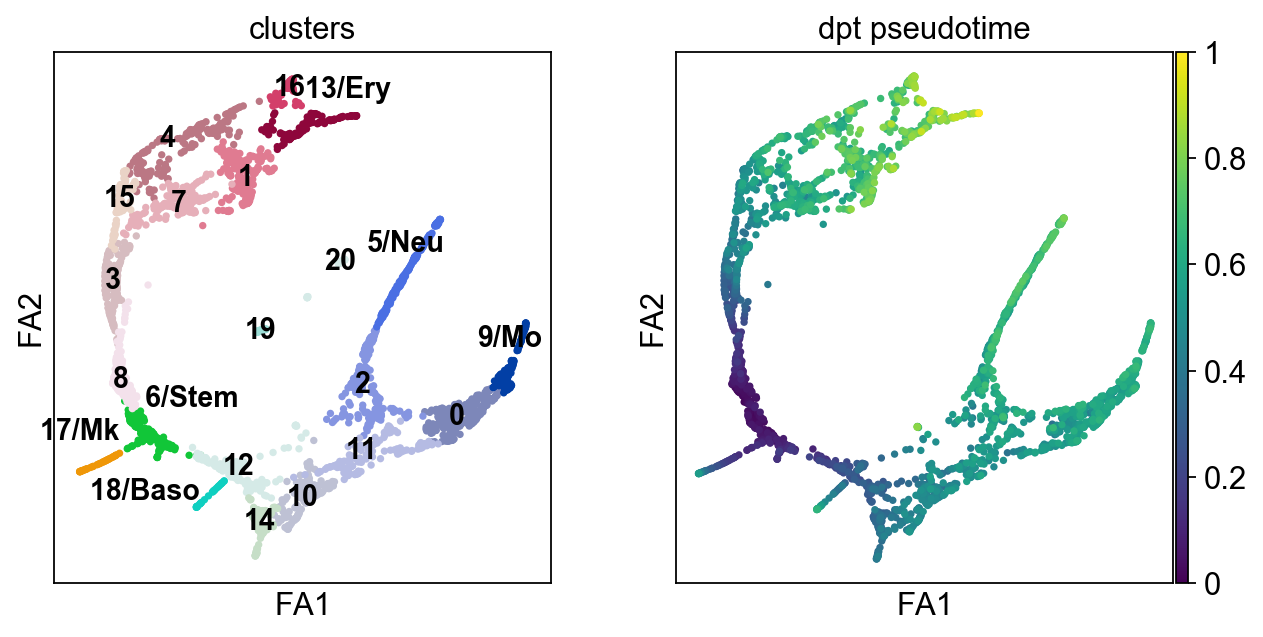

In [69]:
sc.pl.draw_graph(adata, color=['clusters', 'dpt_pseudotime'], legend_loc='on data')

In [70]:
paths = [('erythrocytes', [6, 8, 3, 7, 1, 13]),
         ('neutrophils', [6, 12, 10, 11, 2, 5]),
         ('monocytes', [6, 12, 10, 11, 0, 9])]

In [71]:
adata.obs['distance'] = adata.obs['dpt_pseudotime']

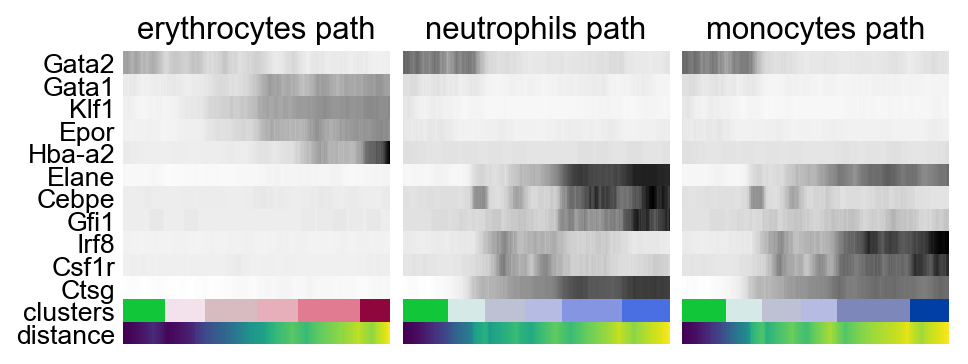

In [72]:
_, axs = pl.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,                         
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
    data.to_csv('./write/paga_path_{}.csv'.format(descr))
pl.savefig('./figures/paga_path_paul15.pdf')
pl.show()